# VMD-GRU-Attention model and fine tuning 

In [1]:
!pip install vmdpy optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from vmdpy import VMD
import optuna

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Ensure plot qualities
plt.rcParams['figure.figsize'] = (12,6)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300  # Adjust DPI for high-resolution figures

In [ ]:
# Global variables
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

K = 8 # Number of IMFs

WINDOW_SIZE = 60
# Default values; these will be tuned via optuna
NUM_NEURONS = 128
DROPOUT_RATE = 0.3
PATIENCE = 10
EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 0.001

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Ensure TensorFlow is using GPU
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU Detected: {device_name}")
else:
    print("No GPU found. Training may be slow.")

GPU Detected: /device:GPU:0


In [ ]:
# Load the data
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/EMH/data/Bitcoin_data_2024_w_TI_n_Macro.csv",
                   index_col=0, parse_dates=True)
data = data[['Returns%']]

# Ensure the data is univariate
if data.shape[1] != 1:
    raise ValueError("Data must be univariate with only 'Returns%' column.")

In [8]:
data.isna().sum()

,0
Returns%,0


In [ ]:
# Split the data
n = len(data)
train_end = int(n * TRAIN_RATIO)
val_end = train_end + int(n * VAL_RATIO)

train_data = data.iloc[:train_end]
val_data   = data.iloc[train_end:val_end]
test_data  = data.iloc[val_end:]

print("Train shape:", train_data.shape)
print("Validation shape:", val_data.shape)
print("Test shape:", test_data.shape)

Train shape: (356589, 1)
Validation shape: (101882, 1)
Test shape: (50943, 1)


In [17]:
# Modified VMD application with proper boundary handling
def safe_vmd_decomposition(main_data, prev_data, window_size):
    """Apply VMD with boundary handling to prevent leakage"""
    extended_data = np.concatenate([prev_data[-window_size:], main_data])
    u, _, _ = VMD(extended_data, alpha=2000, tau=0, K=8, DC=0, init=1, tol=1e-7)
    return u[:, window_size:]  # Trim overlapping portion

# Apply VMD to training data (no previous data)
train_return = train_data['Returns%'].values
u_train, _, _ = VMD(train_return, alpha=2000, tau=0, K=8, DC=0, init=1, tol=1e-7)
vmd_train = pd.DataFrame(u_train.T, columns=[f'IMF_{i}' for i in range(8)], index=train_data.index[:u_train.T.shape[0]])

In [18]:
# Apply VMD to validation data using training boundary
val_return = val_data['Returns%'].values
u_val = safe_vmd_decomposition(val_return, train_return, WINDOW_SIZE)
vmd_val = pd.DataFrame(u_val.T, columns=[f'IMF_{i}' for i in range(8)], index=val_data.index)

In [19]:
# Apply VMD to test data using validation boundary
test_return = test_data['Returns%'].values
u_test = safe_vmd_decomposition(test_return, val_return, WINDOW_SIZE)
vmd_test = pd.DataFrame(u_test.T, columns=[f'IMF_{i}' for i in range(8)], index=test_data.index[:u_test.T.shape[0]])

In [20]:
# Initialize scalers using ONLY training data
scaler_imfs = {}
for i in range(8):
    scaler = MinMaxScaler()
    scaler.fit(vmd_train[[f'IMF_{i}']])  # Train on training IMFs only
    scaler_imfs[f'IMF_{i}'] = scaler

# Scale all sets using training scalers
def safe_scale(df, scaler_dict):
    scaled_df = df.copy()
    for imf in scaler_dict:
        scaled_df[imf] = scaler_dict[imf].transform(df[[imf]])
    return scaled_df

vmd_train = safe_scale(vmd_train, scaler_imfs)
vmd_val = safe_scale(vmd_val, scaler_imfs)
vmd_test = safe_scale(vmd_test, scaler_imfs)

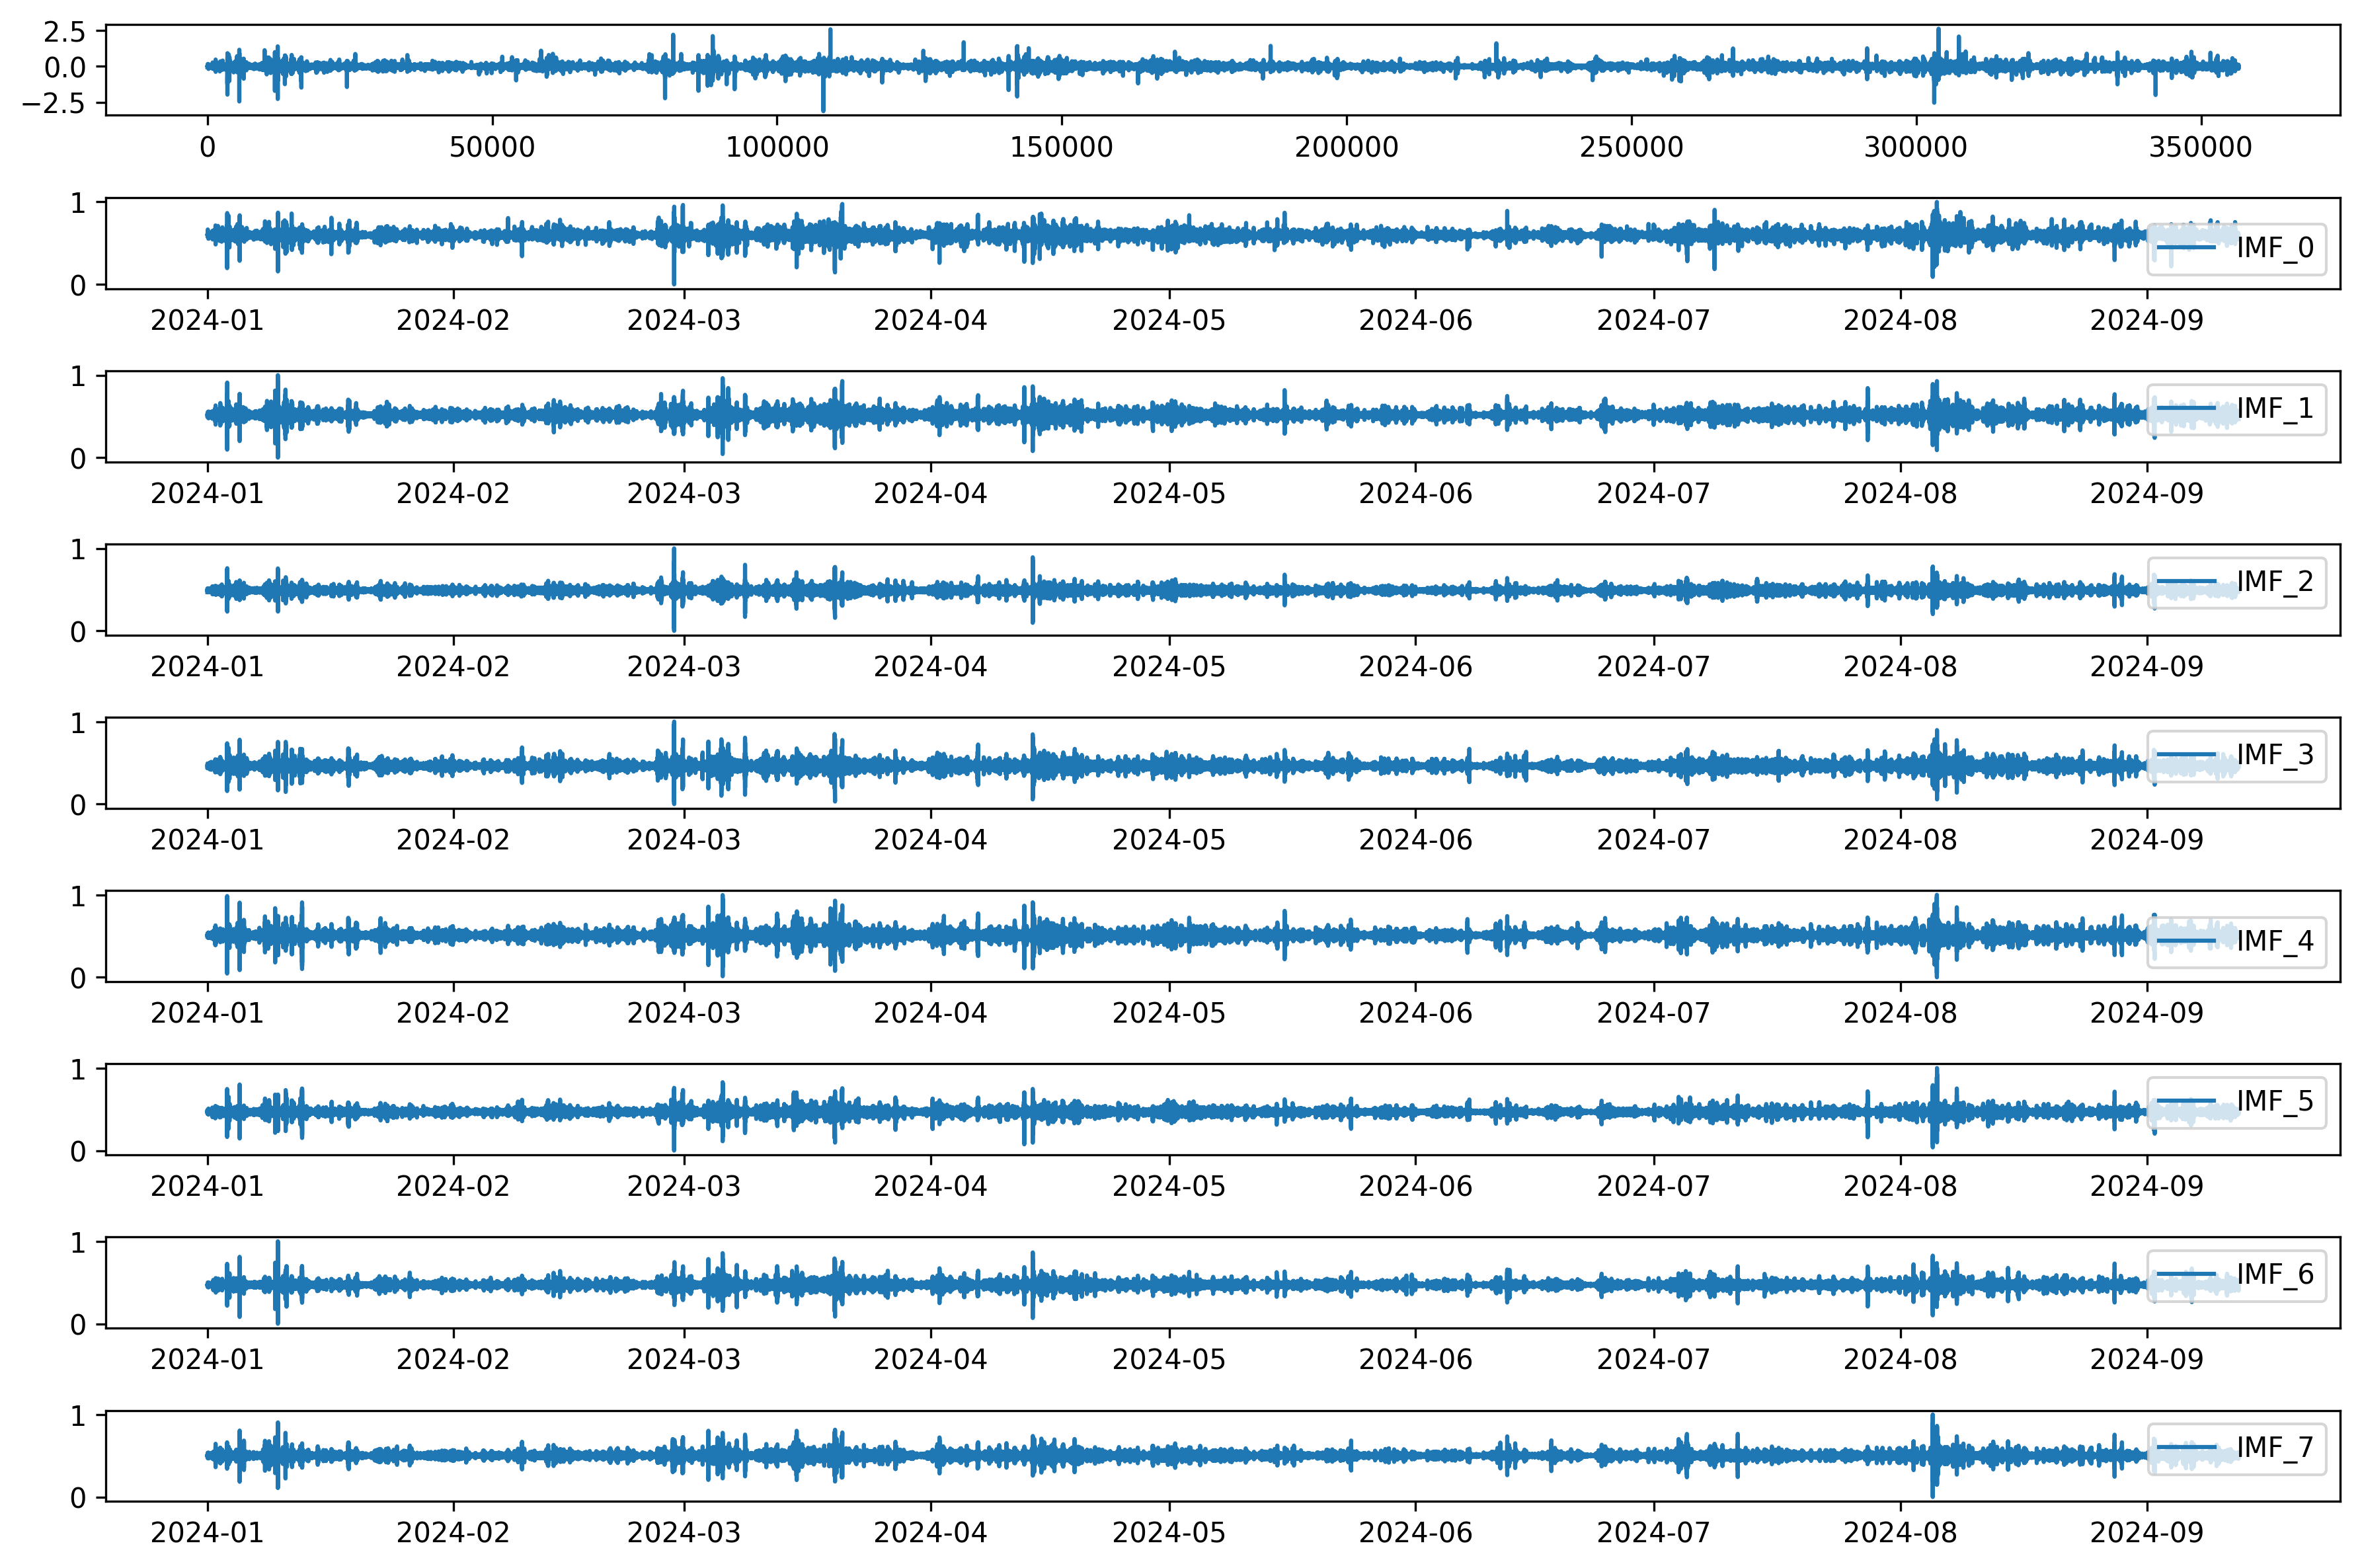

In [35]:
# Plot VMD decomposition for the training period
fig, axs = plt.subplots(K+1, 1, figsize=(12, 8))
axs[0].plot(train_data['Returns%'].values, label="Original Returns")
# axs[0].set_title("Original Returns")
for i in range(K):
    axs[i+1].plot(vmd_train[f'IMF_{i}'], label=f"IMF_{i}")
    axs[i+1].legend()
plt.tight_layout()
plt.show()

In [22]:
# Updated sequence creation with temporal safeguards
def create_leakproof_sequences(df, window_size):
    """Create sequences ensuring no future data contamination"""
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i+window_size].values)
        y.append(df.iloc[i+window_size].values)
    return np.array(X), np.array(y)

# Create sequences for each IMF set
X_train, y_train = create_leakproof_sequences(vmd_train, WINDOW_SIZE)
X_val, y_val = create_leakproof_sequences(vmd_val, WINDOW_SIZE)
X_test, y_test = create_leakproof_sequences(vmd_test, WINDOW_SIZE)

# Reshape for GRU input (samples, timesteps, features)
X_train = X_train.transpose(0, 2, 1)
X_val = X_val.transpose(0, 2, 1)
X_test = X_test.transpose(0, 2, 1)

print("X_train shape:", X_train.shape)  # Expect (samples, K, WINDOW_SIZE)
print("y_train shape:", y_train.shape)

X_train shape: (356528, 8, 60)
y_train shape: (356528, 8)


In [ ]:
# Define the Attention-GRU model with hyperparameter arguments 
def build_attention_gru_model(input_shape, num_neurons, dropout_rate, learning_rate):
    """
    Build an Attention-GRU model with hyperparameters.
    input_shape: (timesteps, features) → here (WINDOW_SIZE, 1)
    """
    print(f"Building model with input shape: {input_shape}, num_neurons: {num_neurons}, dropout_rate: {dropout_rate}, learning_rate: {learning_rate}")
    inputs = Input(shape=input_shape)
    x = GRU(num_neurons, return_sequences=True)(inputs)
    # Using Keras's built-in attention layer (query=key=x)
    x = tf.keras.layers.Attention()([x, x])
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    output = Dense(1)(x)
    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [ ]:
# Hyperparameter tuning with Optuna
def objective(trial):
    # Suggest hyperparameters
    num_neurons = trial.suggest_int("num_neurons", 64, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Build model with suggested hyperparameters
    model = build_attention_gru_model((WINDOW_SIZE, 1), num_neurons, dropout_rate, learning_rate)

    # Use early stopping to avoid overfitting during tuning
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

    # For tuning, use the IMF_0 data (reshape to add channel dimension)
    history = model.fit(
        X_train[:, 0, :].reshape(-1, WINDOW_SIZE, 1),
        y_train[:, 0],
        validation_data=(X_val[:, 0, :].reshape(-1, WINDOW_SIZE, 1), y_val[:, 0]),
        epochs=20,  # Fewer epochs for faster tuning
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0
    )

    # Return the best validation loss achieved during tuning
    val_loss = min(history.history['val_loss'])
    return val_loss

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
best_params = study.best_params
print("Best hyperparameters found:", best_params)

[I 2025-02-19 14:06:58,200] A new study created in memory with name: no-name-f8f8d085-066f-4647-85a1-991889860a6b


Building model with input shape: (60, 1), num_neurons: 96, dropout_rate: 0.17121531505786292, learning_rate: 0.00022307749736166752


[I 2025-02-19 14:09:51,545] Trial 0 finished with value: 1.0921995453827549e-05 and parameters: {'num_neurons': 96, 'dropout_rate': 0.17121531505786292, 'learning_rate': 0.00022307749736166752}. Best is trial 0 with value: 1.0921995453827549e-05.


Building model with input shape: (60, 1), num_neurons: 192, dropout_rate: 0.3100925000190609, learning_rate: 0.004036926225903569


[I 2025-02-19 14:11:08,086] Trial 1 finished with value: 9.893750393530354e-05 and parameters: {'num_neurons': 192, 'dropout_rate': 0.3100925000190609, 'learning_rate': 0.004036926225903569}. Best is trial 0 with value: 1.0921995453827549e-05.


Building model with input shape: (60, 1), num_neurons: 64, dropout_rate: 0.2956772447140329, learning_rate: 0.0014662175879845865


[I 2025-02-19 14:13:50,584] Trial 2 finished with value: 5.084300028102007e-06 and parameters: {'num_neurons': 64, 'dropout_rate': 0.2956772447140329, 'learning_rate': 0.0014662175879845865}. Best is trial 2 with value: 5.084300028102007e-06.


Building model with input shape: (60, 1), num_neurons: 160, dropout_rate: 0.1895441572504462, learning_rate: 0.0011810686117993876


[I 2025-02-19 14:15:16,830] Trial 3 finished with value: 1.943698043760378e-05 and parameters: {'num_neurons': 160, 'dropout_rate': 0.1895441572504462, 'learning_rate': 0.0011810686117993876}. Best is trial 2 with value: 5.084300028102007e-06.


Building model with input shape: (60, 1), num_neurons: 256, dropout_rate: 0.22529321103922087, learning_rate: 0.0053640268326095


[I 2025-02-19 14:16:37,549] Trial 4 finished with value: 0.0007182513363659382 and parameters: {'num_neurons': 256, 'dropout_rate': 0.22529321103922087, 'learning_rate': 0.0053640268326095}. Best is trial 2 with value: 5.084300028102007e-06.


Building model with input shape: (60, 1), num_neurons: 224, dropout_rate: 0.29242408100970574, learning_rate: 0.0010315022261698685


[I 2025-02-19 14:18:11,150] Trial 5 finished with value: 2.63520978478482e-05 and parameters: {'num_neurons': 224, 'dropout_rate': 0.29242408100970574, 'learning_rate': 0.0010315022261698685}. Best is trial 2 with value: 5.084300028102007e-06.


Building model with input shape: (60, 1), num_neurons: 160, dropout_rate: 0.18187625989222794, learning_rate: 0.003825737746495312


[I 2025-02-19 14:19:20,529] Trial 6 finished with value: 5.798477286589332e-05 and parameters: {'num_neurons': 160, 'dropout_rate': 0.18187625989222794, 'learning_rate': 0.003825737746495312}. Best is trial 2 with value: 5.084300028102007e-06.


Building model with input shape: (60, 1), num_neurons: 224, dropout_rate: 0.46880028154976405, learning_rate: 0.008647436748127558


[I 2025-02-19 14:20:53,726] Trial 7 finished with value: 0.00012342241825535893 and parameters: {'num_neurons': 224, 'dropout_rate': 0.46880028154976405, 'learning_rate': 0.008647436748127558}. Best is trial 2 with value: 5.084300028102007e-06.


Building model with input shape: (60, 1), num_neurons: 96, dropout_rate: 0.22539429493577767, learning_rate: 0.0001816586461597136


[I 2025-02-19 14:23:34,725] Trial 8 finished with value: 2.0369290723465383e-05 and parameters: {'num_neurons': 96, 'dropout_rate': 0.22539429493577767, 'learning_rate': 0.0001816586461597136}. Best is trial 2 with value: 5.084300028102007e-06.


Building model with input shape: (60, 1), num_neurons: 96, dropout_rate: 0.46812954265560514, learning_rate: 0.0002417090515952868


[I 2025-02-19 14:26:25,391] Trial 9 finished with value: 1.3974496141599957e-05 and parameters: {'num_neurons': 96, 'dropout_rate': 0.46812954265560514, 'learning_rate': 0.0002417090515952868}. Best is trial 2 with value: 5.084300028102007e-06.


Building model with input shape: (60, 1), num_neurons: 64, dropout_rate: 0.10155792007511644, learning_rate: 0.0005604560695866363


[I 2025-02-19 14:29:07,550] Trial 10 finished with value: 7.3211913331761025e-06 and parameters: {'num_neurons': 64, 'dropout_rate': 0.10155792007511644, 'learning_rate': 0.0005604560695866363}. Best is trial 2 with value: 5.084300028102007e-06.


Building model with input shape: (60, 1), num_neurons: 64, dropout_rate: 0.10635392226404468, learning_rate: 0.0005111175724062612


[I 2025-02-19 14:32:00,851] Trial 11 finished with value: 4.9112591113953386e-06 and parameters: {'num_neurons': 64, 'dropout_rate': 0.10635392226404468, 'learning_rate': 0.0005111175724062612}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 64, dropout_rate: 0.3840563170910586, learning_rate: 0.000544604885429773


[I 2025-02-19 14:34:53,192] Trial 12 finished with value: 7.084297067194711e-06 and parameters: {'num_neurons': 64, 'dropout_rate': 0.3840563170910586, 'learning_rate': 0.000544604885429773}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 128, dropout_rate: 0.10868595185210977, learning_rate: 0.001830153346752035


[I 2025-02-19 14:36:19,806] Trial 13 finished with value: 3.0245490052038804e-05 and parameters: {'num_neurons': 128, 'dropout_rate': 0.10868595185210977, 'learning_rate': 0.001830153346752035}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 64, dropout_rate: 0.3674376948747934, learning_rate: 0.000610571231321294


[I 2025-02-19 14:39:13,350] Trial 14 finished with value: 5.177288130653324e-06 and parameters: {'num_neurons': 64, 'dropout_rate': 0.3674376948747934, 'learning_rate': 0.000610571231321294}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 128, dropout_rate: 0.2974505106447638, learning_rate: 0.00010267202359583976


[I 2025-02-19 14:42:06,732] Trial 15 finished with value: 1.781918399501592e-05 and parameters: {'num_neurons': 128, 'dropout_rate': 0.2974505106447638, 'learning_rate': 0.00010267202359583976}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 128, dropout_rate: 0.4019356829020114, learning_rate: 0.002531531448921017


[I 2025-02-19 14:43:08,309] Trial 16 finished with value: 5.3505038522416726e-05 and parameters: {'num_neurons': 128, 'dropout_rate': 0.4019356829020114, 'learning_rate': 0.002531531448921017}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 64, dropout_rate: 0.24793610650672535, learning_rate: 0.0003740951049213944


[I 2025-02-19 14:46:00,616] Trial 17 finished with value: 8.878003427525982e-06 and parameters: {'num_neurons': 64, 'dropout_rate': 0.24793610650672535, 'learning_rate': 0.0003740951049213944}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 96, dropout_rate: 0.14579965761390773, learning_rate: 0.0016090035728072117


[I 2025-02-19 14:47:34,954] Trial 18 finished with value: 1.8070266378344968e-05 and parameters: {'num_neurons': 96, 'dropout_rate': 0.14579965761390773, 'learning_rate': 0.0016090035728072117}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 160, dropout_rate: 0.3392106000201619, learning_rate: 0.0007139176282555318


[I 2025-02-19 14:49:43,677] Trial 19 finished with value: 1.0027237294707447e-05 and parameters: {'num_neurons': 160, 'dropout_rate': 0.3392106000201619, 'learning_rate': 0.0007139176282555318}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 64, dropout_rate: 0.4192627135146364, learning_rate: 0.0003775068562817573


[I 2025-02-19 14:52:34,020] Trial 20 finished with value: 8.626689123047981e-06 and parameters: {'num_neurons': 64, 'dropout_rate': 0.4192627135146364, 'learning_rate': 0.0003775068562817573}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 64, dropout_rate: 0.34746169965329704, learning_rate: 0.00087710430029745


[I 2025-02-19 14:55:24,358] Trial 21 finished with value: 5.279106517264154e-06 and parameters: {'num_neurons': 64, 'dropout_rate': 0.34746169965329704, 'learning_rate': 0.00087710430029745}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 96, dropout_rate: 0.43241957911564644, learning_rate: 0.0003637142038693277


[I 2025-02-19 14:58:12,295] Trial 22 finished with value: 6.578469765372574e-06 and parameters: {'num_neurons': 96, 'dropout_rate': 0.43241957911564644, 'learning_rate': 0.0003637142038693277}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 64, dropout_rate: 0.3608661800189343, learning_rate: 0.0015059117338210581


[I 2025-02-19 15:00:19,371] Trial 23 finished with value: 6.4003284023783635e-06 and parameters: {'num_neurons': 64, 'dropout_rate': 0.3608661800189343, 'learning_rate': 0.0015059117338210581}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 128, dropout_rate: 0.24556330494727707, learning_rate: 0.0006514519300824326


[I 2025-02-19 15:02:51,219] Trial 24 finished with value: 6.378394118655706e-06 and parameters: {'num_neurons': 128, 'dropout_rate': 0.24556330494727707, 'learning_rate': 0.0006514519300824326}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 96, dropout_rate: 0.2842111429586446, learning_rate: 0.00282116437585408


[I 2025-02-19 15:05:23,817] Trial 25 finished with value: 1.0874604413402267e-05 and parameters: {'num_neurons': 96, 'dropout_rate': 0.2842111429586446, 'learning_rate': 0.00282116437585408}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 64, dropout_rate: 0.49497004103732123, learning_rate: 0.001178387026470639


[I 2025-02-19 15:08:14,808] Trial 26 finished with value: 5.169436008145567e-06 and parameters: {'num_neurons': 64, 'dropout_rate': 0.49497004103732123, 'learning_rate': 0.001178387026470639}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 96, dropout_rate: 0.4947194591379084, learning_rate: 0.0024341275228507092


[I 2025-02-19 15:09:41,544] Trial 27 finished with value: 2.297935134265572e-05 and parameters: {'num_neurons': 96, 'dropout_rate': 0.4947194591379084, 'learning_rate': 0.0024341275228507092}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 64, dropout_rate: 0.26478502338176335, learning_rate: 0.001232870333955396


[I 2025-02-19 15:12:00,104] Trial 28 finished with value: 6.137986019894015e-06 and parameters: {'num_neurons': 64, 'dropout_rate': 0.26478502338176335, 'learning_rate': 0.001232870333955396}. Best is trial 11 with value: 4.9112591113953386e-06.


Building model with input shape: (60, 1), num_neurons: 96, dropout_rate: 0.32529778298768164, learning_rate: 0.0002188991491300483


[I 2025-02-19 15:14:50,737] Trial 29 finished with value: 1.2675259313255083e-05 and parameters: {'num_neurons': 96, 'dropout_rate': 0.32529778298768164, 'learning_rate': 0.0002188991491300483}. Best is trial 11 with value: 4.9112591113953386e-06.


Best hyperparameters found: {'num_neurons': 64, 'dropout_rate': 0.10635392226404468, 'learning_rate': 0.0005111175724062612}


In [ ]:
# Best hyperparameters found: {'num_neurons': 64, 'dropout_rate': 0.10635392226404468, 'learning_rate': 0.0005111175724062612}

In [ ]:
# Model training using the best hyperparameters 
def train_imf_model(imf_index, X_train, y_train, X_val, y_val, num_neurons, dropout_rate, learning_rate):
    model = build_attention_gru_model((WINDOW_SIZE, 1), num_neurons, dropout_rate, learning_rate)
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True,
        mode='min'
    )

    history = model.fit(
        X_train[:, imf_index, :].reshape(-1, WINDOW_SIZE, 1),
        y_train[:, imf_index],
        validation_data=(X_val[:, imf_index, :].reshape(-1, WINDOW_SIZE, 1), y_val[:, imf_index]),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop],
        verbose=1
    )
    return model, history

# Train models for each IMF using the best hyperparameters from optuna
models = []
for i in range(8):
    print(f"\nTraining model for IMF_{i}...")
    model, _ = train_imf_model(i, X_train, y_train, X_val, y_val,
                               num_neurons=best_params['num_neurons'],
                               dropout_rate=best_params['dropout_rate'],
                               learning_rate=best_params['learning_rate'])
    models.append(model)


Training model for IMF_0...
Building model with input shape: (60, 1), num_neurons: 64, dropout_rate: 0.10635392226404468, learning_rate: 0.0005111175724062612
Epoch 1/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0069 - val_loss: 7.9381e-04
Epoch 2/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0013 - val_loss: 7.1881e-04
Epoch 3/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0011 - val_loss: 6.1076e-04
Epoch 4/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 8.6662e-04 - val_loss: 2.3341e-04
Epoch 5/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 2.5531e-04 - val_loss: 6.7928e-05
Epoch 6/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1.0831e-04 - val_loss: 3.8297e-05
Epoch 7/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 8.1422e-05 - val_loss: 2.7016e-05
Epoch 8/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6.1140e-05 - val_loss: 2.9447e-05
Epoch 9/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 5.5813e-05 -

In [26]:
import joblib

# Save the scalers dictionary
scaler_save_path = "/content/drive/My Drive/Colab Notebooks/EMH/models/scaler_imfs.pkl"
joblib.dump(scaler_imfs, scaler_save_path)
print("Scalers saved successfully to", scaler_save_path)

# Save each model
for i, model in enumerate(models):
    model_save_path = f"/content/drive/My Drive/Colab Notebooks/EMH/models/model_imf_{i}.keras"
    model.save(model_save_path)
    print(f"Model for IMF_{i} saved successfully to {model_save_path}")

# Save decomposed IMF data
vmd_train.to_csv("/content/drive/My Drive/Colab Notebooks/EMH/models/vmd_train.csv")
vmd_val.to_csv("/content/drive/My Drive/Colab Notebooks/EMH/models/vmd_val.csv")
vmd_test.to_csv("/content/drive/My Drive/Colab Notebooks/EMH/models/vmd_test.csv")
print("IMF CSV files saved successfully!")

# Save ground truth labels
np.save("/content/drive/My Drive/Colab Notebooks/EMH/models/y_val.npy", y_val)
np.save("/content/drive/My Drive/Colab Notebooks/EMH/models/y_test.npy", y_test)

# Save evaluation features
np.save("/content/drive/My Drive/Colab Notebooks/EMH/models/X_val.npy", X_val)
np.save("/content/drive/My Drive/Colab Notebooks/EMH/models/X_test.npy", X_test)

print("NumPy arrays for features and labels saved successfully!")

Scalers saved successfully to /content/drive/My Drive/Colab Notebooks/EMH/models/scaler_imfs.pkl
Model for IMF_0 saved successfully to /content/drive/My Drive/Colab Notebooks/EMH/models/model_imf_0.keras
Model for IMF_1 saved successfully to /content/drive/My Drive/Colab Notebooks/EMH/models/model_imf_1.keras
Model for IMF_2 saved successfully to /content/drive/My Drive/Colab Notebooks/EMH/models/model_imf_2.keras
Model for IMF_3 saved successfully to /content/drive/My Drive/Colab Notebooks/EMH/models/model_imf_3.keras
Model for IMF_4 saved successfully to /content/drive/My Drive/Colab Notebooks/EMH/models/model_imf_4.keras
Model for IMF_5 saved successfully to /content/drive/My Drive/Colab Notebooks/EMH/models/model_imf_5.keras
Model for IMF_6 saved successfully to /content/drive/My Drive/Colab Notebooks/EMH/models/model_imf_6.keras
Model for IMF_7 saved successfully to /content/drive/My Drive/Colab Notebooks/EMH/models/model_imf_7.keras
IMF CSV files saved successfully!
NumPy arrays 

## Evaluation
### Val set evaluation

In [27]:
def safe_predict(models, X_set, scalers):
    """Make predictions without data leakage"""
    pred_imfs = []
    for i, model in enumerate(models):
        pred = model.predict(X_set[:, i, :])
        pred_imfs.append(scalers[f'IMF_{i}'].inverse_transform(pred))
    return np.sum(pred_imfs, axis=0)

# Generate final predictions
y_val_pred = safe_predict(models, X_val, scaler_imfs)
y_test_pred = safe_predict(models, X_test, scaler_imfs)

# Get actual values with proper window offset
actual_val = val_data['Returns%'].values[WINDOW_SIZE:]
actual_test = test_data['Returns%'].values[WINDOW_SIZE:]

3182/3182 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3182/3182 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [ ]:
# Evaluate on validation set

# Error metrics
mae_val = mean_absolute_error(actual_val, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(actual_val, y_val_pred))
mape_val = mean_absolute_percentage_error(actual_val, y_val_pred) * 100

print("Validation Set Metrics:")
print(f"MAE:  {mae_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")

Validation Set Metrics:
MAE:  0.0141
RMSE: 0.0211


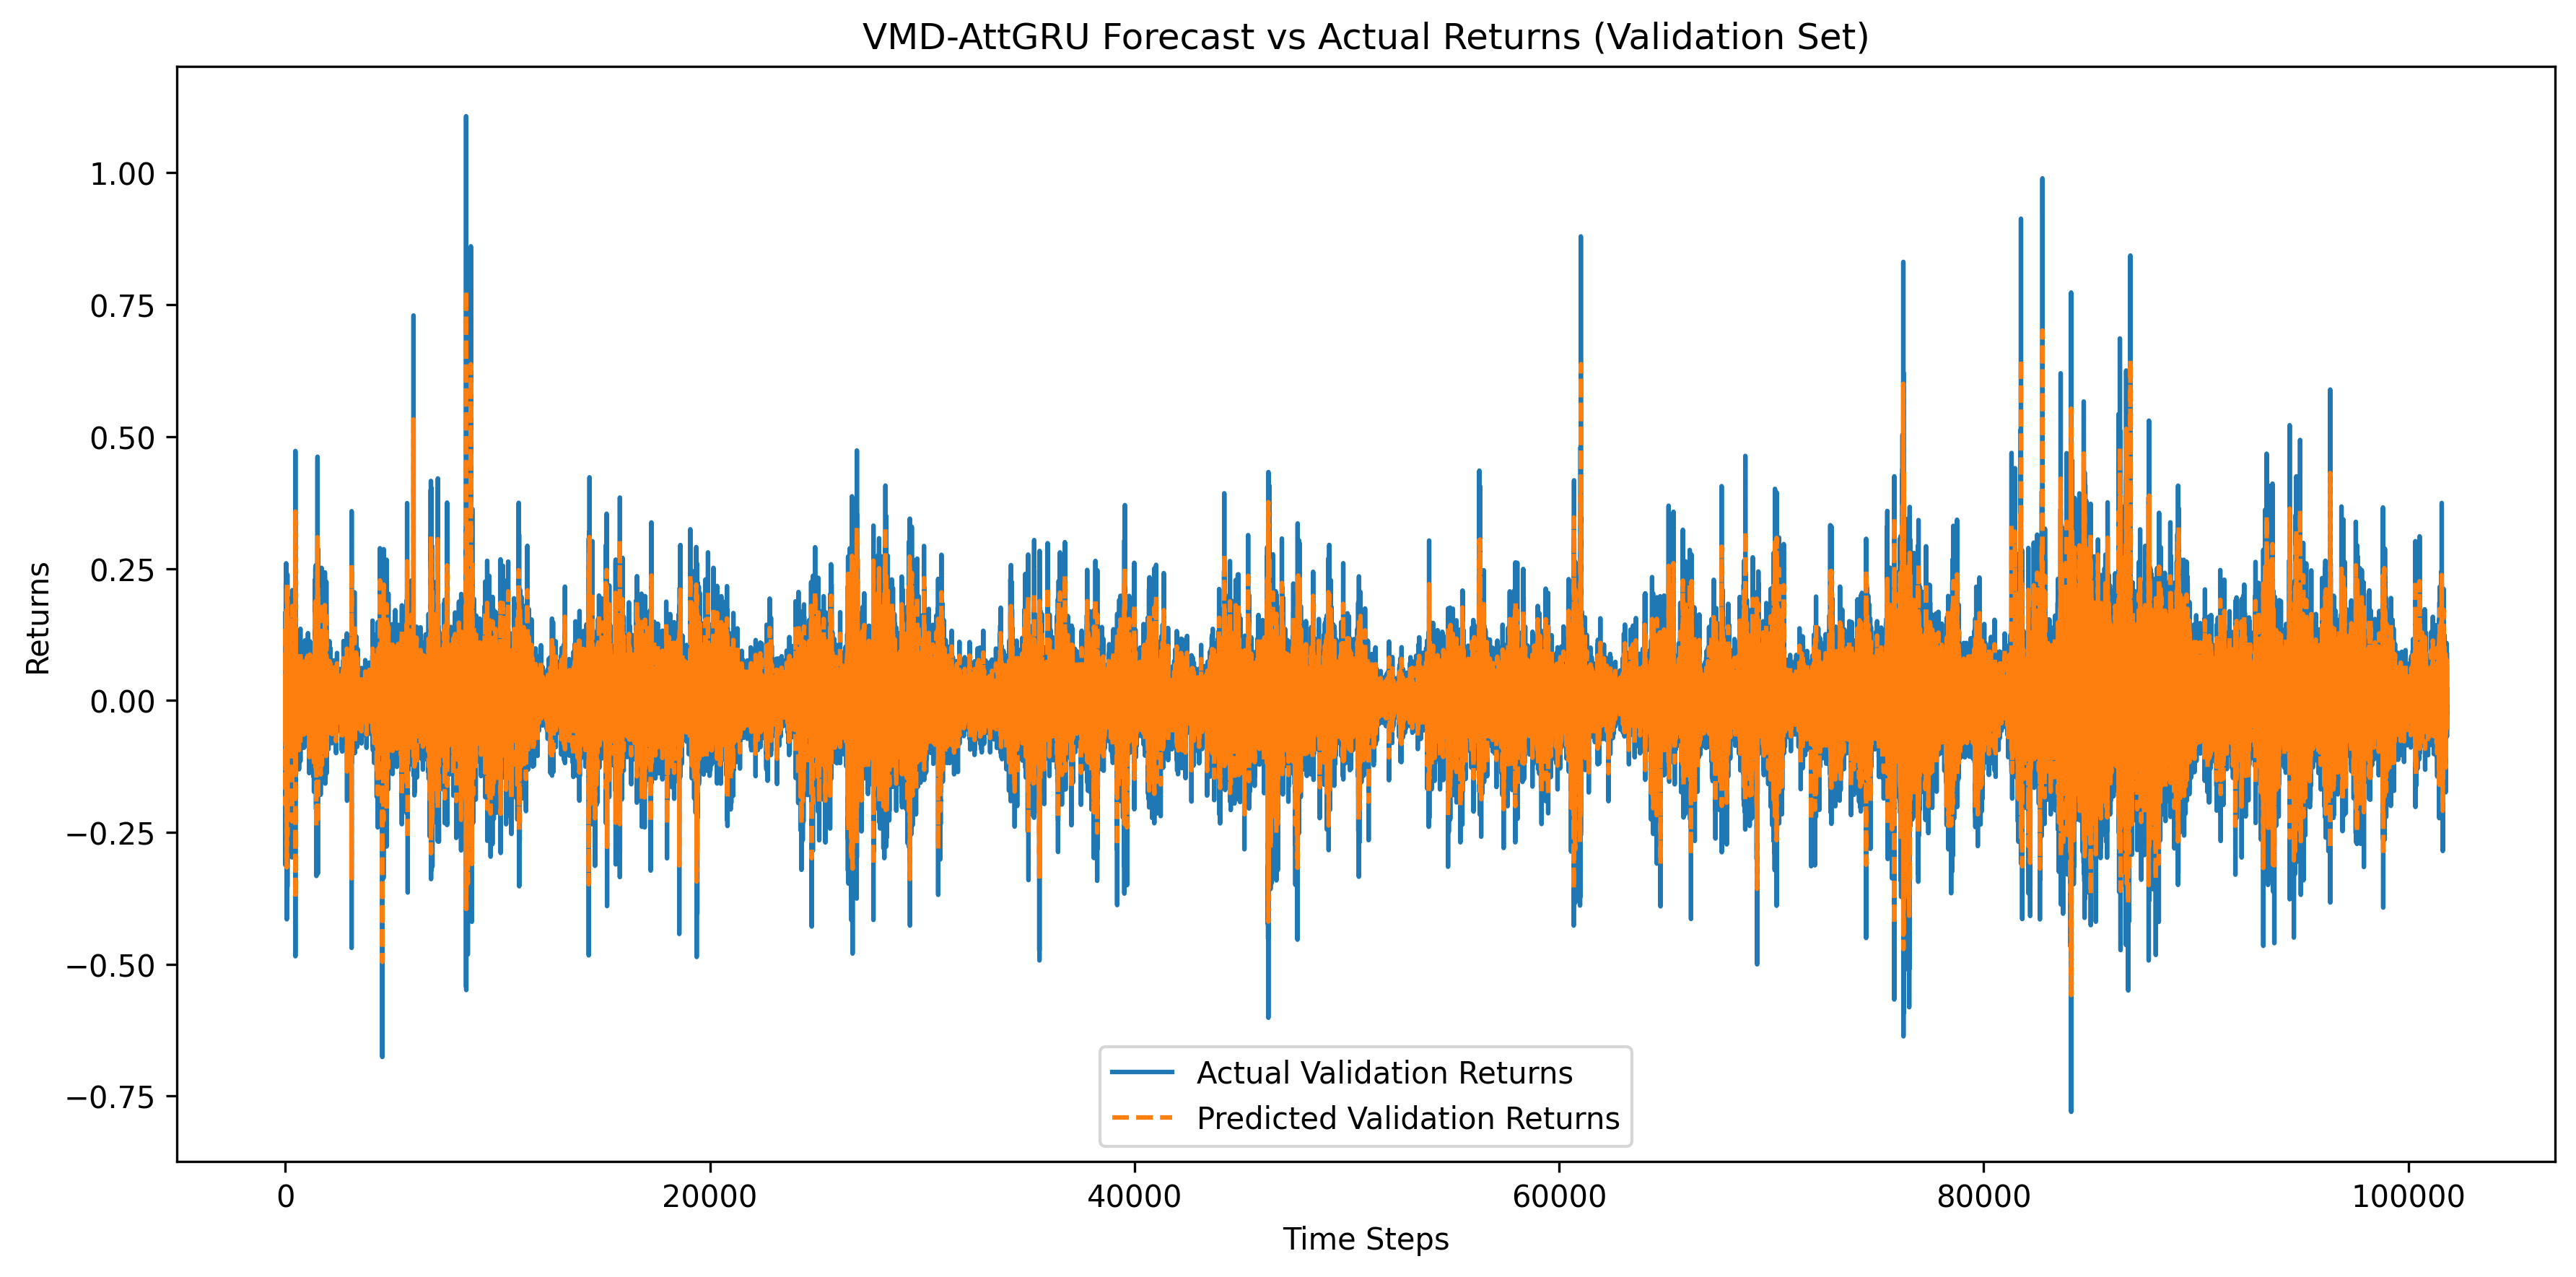

In [ ]:
# Plot predicted vs actual for validation set
plt.figure(figsize=(12, 6))
plt.plot(actual_val, label='Actual Validation Returns')
plt.plot(y_val_pred, label='Predicted Validation Returns', linestyle='--')
plt.title('VMD-AttGRU Forecast vs Actual Returns (Validation Set)')
plt.xlabel('Time Steps')
plt.ylabel('Returns')
plt.legend()
plt.tight_layout()
plt.show()

### Test set evaluation

In [ ]:
# Evaluate on test set 

# Error metrics
actual_test = actual_test[:y_test_pred.shape[0]] # due to 'vmd_test' trimming earlier

mae_test = mean_absolute_error(actual_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(actual_test, y_test_pred))
mape_test = mean_absolute_percentage_error(actual_test, y_test_pred) * 100

print("Test Set Metrics:")
print(f"MAE:  {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

Test Set Metrics:
MAE:  0.0158
RMSE: 0.0239


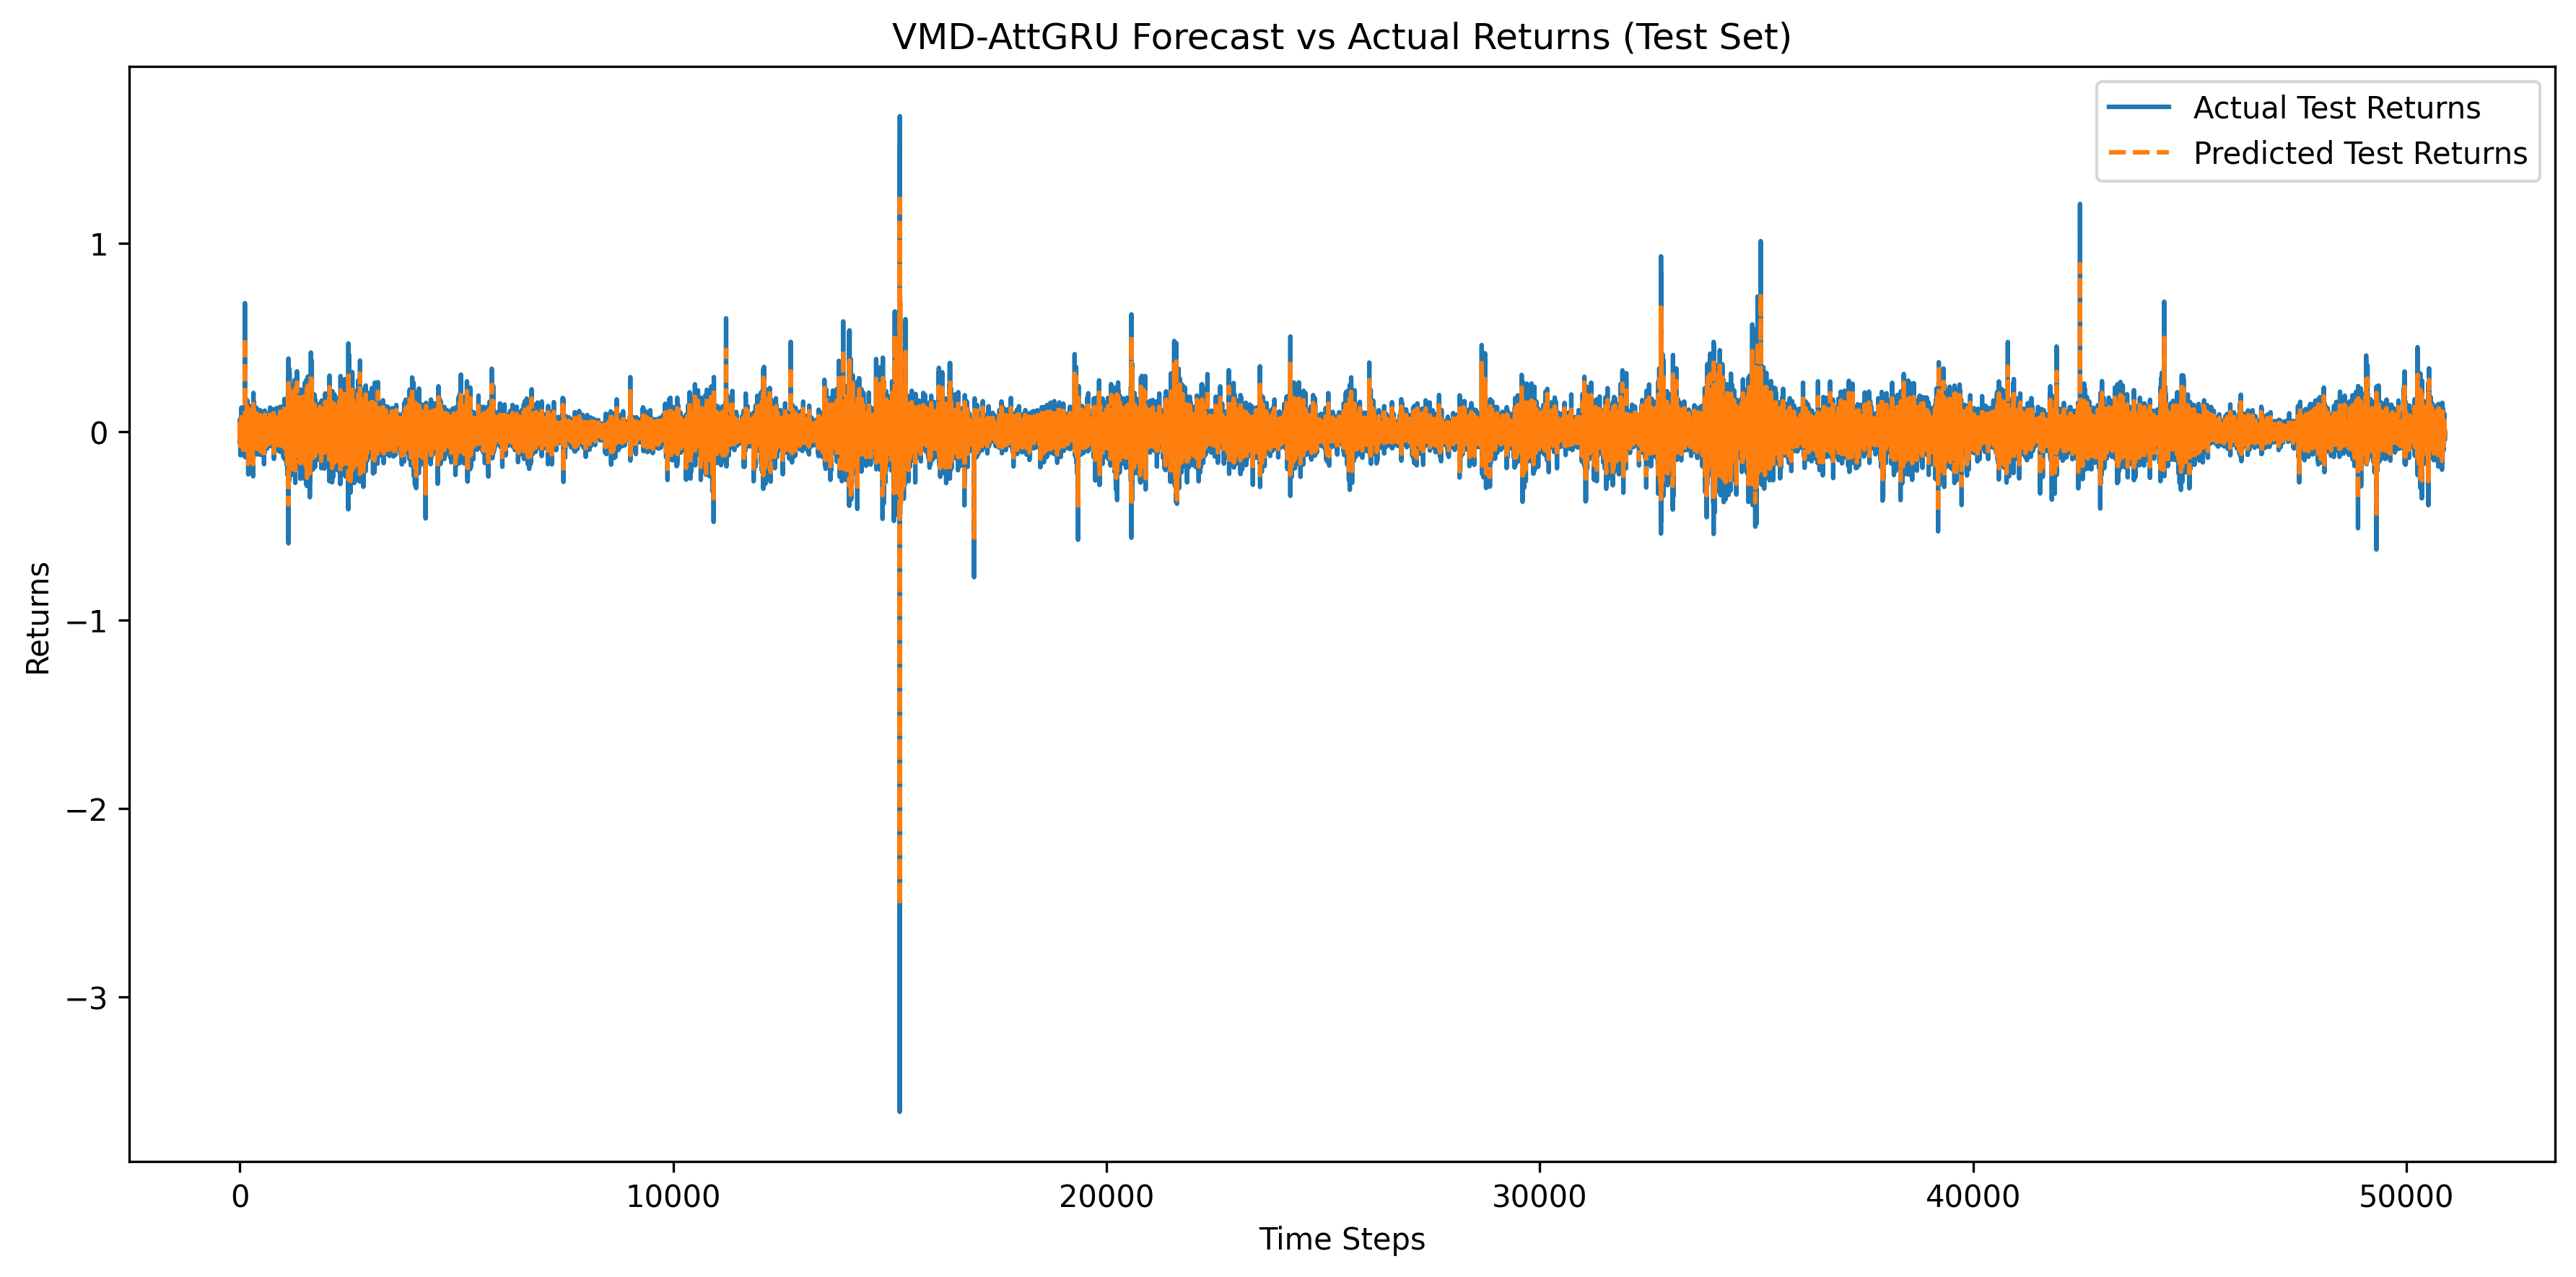

In [ ]:
# Plot predicted vs actual for test set
plt.figure(figsize=(12, 6))
plt.plot(actual_test, label='Actual Test Returns')
plt.plot(y_test_pred, label='Predicted Test Returns', linestyle='--')
plt.title('VMD-AttGRU Forecast vs Actual Returns (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Returns')
plt.legend()
plt.tight_layout()
plt.show()